<a href="https://colab.research.google.com/github/marmal88/Cars/blob/main/Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Identification dataset

In [1]:
jupyter nbconvert Cars.ipynb --to python
pipreqs --force .
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preliminary EDA from csv

In [106]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os

In [110]:
names_df = pd.read_csv('data/annotations/class_names.csv', header=None)
names_df.rename(columns={0:"class_names"}, inplace=True)
names_df.index = (np.arange(1, len(names_df) + 1))

data_df = pd.read_csv('data/annotations/cars_annos.csv', sep=";")

In [121]:
df = pd.merge(data_df, names_df, how='inner', left_on="class", right_index=True)
col = {x:x.lower() for x in df.columns}
df.rename(columns=col, inplace=True)

df.head()

,image,x1,y1,x2,y2,class,test,class_names
0,000001.jpg,112,7,853,717,1,0,AM General Hummer SUV 2000
1,000002.jpg,48,24,441,202,1,0,AM General Hummer SUV 2000
2,000003.jpg,7,4,277,180,1,0,AM General Hummer SUV 2000
3,000004.jpg,33,50,197,150,1,0,AM General Hummer SUV 2000
4,000005.jpg,5,8,83,58,1,0,AM General Hummer SUV 2000


In [112]:
df.shape

(16185, 8)

In [115]:
# Check to see if the dataset split is already fair by ensuring stratification of classes over the train and test set
test_df = df.loc[df["test"]==1, "class"]
train_df = df.loc[df["test"]==0, "class"]

print(f"total number of classes entire dataset {df['class'].nunique()}")
print(f'total number of classes in test set {test_df.nunique()}')
print(f'total number of classes in test set {train_df.nunique()}')

total number of classes entire dataset 196
total number of classes in test set 196
total number of classes in test set 196


005351.jpg 62 38 482 311 420 273 Chevrolet Cobalt SS 2010
004858.jpg 28 2 799 541 771 539 Chevrolet HHR SS 2010
009406.jpg 19 74 490 341 471 267 Ford Focus Sedan 2007
007286.jpg 127 50 751 549 624 499 Dodge Journey SUV 2012
000799.jpg 270 350 1011 608 741 258 Aston Martin Virage Convertible 2012


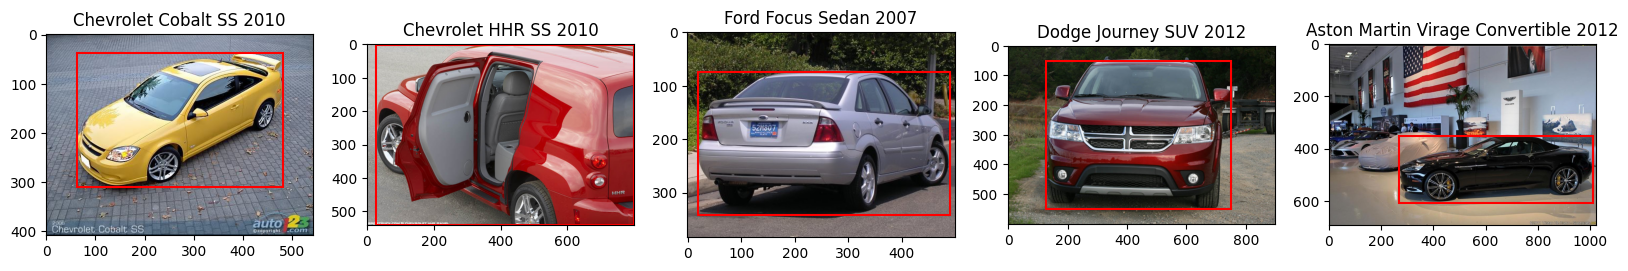

In [134]:
# Random check to see if bounding boxes are able to completely cover the car in question

plt.figure(figsize=(20,20))
for i in range(5):
    rand = np.random.randint(len(df))
    img_name, x1, y1, x2, y2, _, _, class_names = df.iloc[rand,:]

    width, height = x2-x1, y2-y1
    print(img_name, x1, y1, x2, y2, width, height, class_names)
    img = Image.open(f'data/car_ims/{img_name}')
    ax=plt.subplot(1,5,i+1)
    plt.imshow(img)
    rect = Rectangle((x1, y1), width, height, linewidth=1.5, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.title(f"{class_names}")

plt.show()

In [107]:
# Check to see if there are different modes in the dataset RGB vs RGBA
df["ext"] = df["Image"].apply(lambda x: os.path.splitext(x)[1])
df.ext.unique()

array(['.jpg'], dtype=object)

# Call dependencies



In [2]:
import torchvision
import pandas
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.image[idx])
        image = Image.imread(img_name)
        bbox = self.dataframe.iloc[idx, 1:4]
        bbox = np.array([bbox])
        bbox = bbox.astype('float').reshape(-1, 2)
        sample = {'image': image, 'bbox': bbox}

        if self.transform:
            sample = self.transform(sample)

        return sample